In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import make_scorer
import tensorflow as tf
from tensorflow.python.data import Dataset

import glob
import os
from itertools import repeat
import xgboost
from sklearn.model_selection import train_test_split
import seaborn as sns

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

#california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

#california_housing_dataframe = california_housing_dataframe.reindex(
 #   np.random.permutation(california_housing_dataframe.index))

In [0]:
folder_path = "/content/drive/My Drive/Muon"
SIMPLE_FEATURE_COLUMNS = ['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]','avg_cs[1]', 'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]', 'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
                          'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]', 'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]', 
                          'MatchedHit_Z[1]','MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
                          'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]', 'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]', 'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
                          'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]', 'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]', 'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]', 'Lextra_Y[1]', 
                          'Lextra_Y[2]', 'Lextra_Y[3]', 'NShared', 'Mextra_DX2[0]','Mextra_DX2[1]', 'Mextra_DX2[2]', 'Mextra_DX2[3]', 'Mextra_DY2[0]',
                          'Mextra_DY2[1]', 'Mextra_DY2[2]', 'Mextra_DY2[3]', 'FOI_hits_N', 'PT', 'P']

TRAIN_COLUMNS = ["label", "weight"]

FOI_COLUMNS = ["FOI_hits_X", "FOI_hits_Y", "FOI_hits_T",
               "FOI_hits_Z", "FOI_hits_DX", "FOI_hits_DY", "FOI_hits_S"]

ID_COLUMN = "id"

N_STATIONS = 4
FEATURES_PER_STATION = 6
N_FOI_FEATURES = N_STATIONS*FEATURES_PER_STATION
# The value to use for stations with missing hits
# when computing FOI features
EMPTY_FILLER = 1000

# Examples on working with the provided files in different ways

# hdf is all fine - but it requires unpickling the numpy arrays
# which is not guranteed

def load_data_csv(path, feature_columns):
    train = pd.concat([
        pd.read_csv(os.path.join(path, "train_part_%i.csv.gz" % i),
                    usecols= [ID_COLUMN] + feature_columns + TRAIN_COLUMNS,
                    index_col=ID_COLUMN)
        for i in (1, 2)], axis=0, ignore_index=True)
    test = pd.read_csv(os.path.join(path, "test_public_v2.csv.gz"),
                       usecols=[ID_COLUMN] + feature_columns, index_col=ID_COLUMN)
    return train, test
  

def rename_column (matrix):
     matrix.rename(columns={'ncl[0]' : 'ncl_0', 'ncl[1]' : 'ncl_1', 'ncl[2]' : 'ncl_2', 'ncl[3]' : 'ncl_3', 'avg_cs[0]' : 'avg_cs_0', 'avg_cs[1]' : 'avg_cs_1',  'avg_cs[2]' : 'avg_cs_2', 'avg_cs[3]' : 'avg_cs_3', 
                   
                   'ndof' : 'ndof', 'MatchedHit_TYPE[0]' : 'MatchedHit_TYPE_0', 'MatchedHit_TYPE[1]' : 'MatchedHit_TYPE_1','MatchedHit_TYPE[2]' : 'MatchedHit_TYPE_2', 'MatchedHit_TYPE[3]' : 'MatchedHit_TYPE_3',
                   
                   'MatchedHit_X[0]' : 'MatchedHit_X_0',  'MatchedHit_X[1]' : 'MatchedHit_X_1', 'MatchedHit_X[2]' : 'MatchedHit_X_2','MatchedHit_X[3]' : 'MatchedHit_X_3','MatchedHit_Y[0]' : 'MatchedHit_Y_0', 
                   'MatchedHit_Y[1]' : 'MatchedHit_Y_1','MatchedHit_Y[2]' : 'MatchedHit_Y_2', 'MatchedHit_Y[3]' : 'MatchedHit_Y_3', 'MatchedHit_Z[0]' : 'MatchedHit_Z_0', 'MatchedHit_Z[1]' : 'MatchedHit_Z_1', 
                   'MatchedHit_Z[2]' : 'MatchedHit_Z_2', 'MatchedHit_Z[3]' : 'MatchedHit_Z_3','MatchedHit_DX[0]' : 'MatchedHit_DX_0', 'MatchedHit_DX[1]' : 'MatchedHit_DX_1', 'MatchedHit_DX[2]' : 'MatchedHit_DX_2','MatchedHit_DX[3]' : 'MatchedHit_DX_3',
                   
                   'MatchedHit_DY[0]' : 'MatchedHit_DY_0','MatchedHit_DY[1]' : 'MatchedHit_DY_1','MatchedHit_DY[2]' : 'MatchedHit_DY_2','MatchedHit_DY[3]' : 'MatchedHit_DY_3', 
                   
                   'MatchedHit_DZ[0]' : 'MatchedHit_DZ_0', 'MatchedHit_DZ[1]' : 'MatchedHit_DZ_1',  'MatchedHit_DZ[2]' : 'MatchedHit_DZ_2', 'MatchedHit_DZ[3]' : 'MatchedHit_DZ_3',
                   
                   'MatchedHit_T[0]' : 'MatchedHit_T_0', 'MatchedHit_T[1]' : 'MatchedHit_T_1', 'MatchedHit_T[2]' : 'MatchedHit_T_2','MatchedHit_T[3]' : 'MatchedHit_T_3', 
                   
                   'MatchedHit_DT[0]' : 'MatchedHit_DT_0',
                   'MatchedHit_DT[1]' : 'MatchedHit_DT_1',
                   'MatchedHit_DT[2]' : 'MatchedHit_DT_2', 
                   'MatchedHit_DT[3]' : 'MatchedHit_DT_3',
                   
                   'Lextra_X[0]' : 'Lextra_X_0', 
                   'Lextra_X[1]' : 'Lextra_X_1',
                   'Lextra_X[2]' : 'Lextra_X_2', 
                   'Lextra_X[3]' : 'Lextra_X_3',
                   
                   'Lextra_Y[0]' : 'Lextra_Y_0', 
                   'Lextra_Y[1]' : 'Lextra_Y_1',
                   'Lextra_Y[2]' : 'Lextra_Y_2', 
                   'Lextra_Y[3]' : 'Lextra_Y_3', 
                  
                   'NShared' : 'NShared', 
                   
                   'Mextra_DX2[0]' : 'Mextra_DX2_0',
                   'Mextra_DX2[1]' : 'Mextra_DX2_1', 
                   'Mextra_DX2[2]' : 'Mextra_DX2_2', 
                   'Mextra_DX2[3]' : 'Mextra_DX2_3', 
                   
                   'Mextra_DY2[0]' : 'Mextra_DY2_0',
                   'Mextra_DY2[1]' : 'Mextra_DY2_1', 
                   'Mextra_DY2[2]' : 'Mextra_DY2_2', 
                   'Mextra_DY2[3]' : 'Mextra_DY2_3'}, 
          inplace=True)

     return matrix

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[[ 
                   'ncl_0', 
                   'ncl_1', 
                   'ncl_2', 
                   'ncl_3', 
                   
                   'avg_cs_0',
                   'avg_cs_1', 
                   'avg_cs_2', 
                   'avg_cs_3', 
                   
                   'ndof', 
                  
                   'MatchedHit_TYPE_0',
                   'MatchedHit_TYPE_1', 
                   'MatchedHit_TYPE_2',
                   'MatchedHit_TYPE_3',
                   
                   'MatchedHit_X_0', 
                   'MatchedHit_X_1', 
                   'MatchedHit_X_2',
                   'MatchedHit_X_3', 
                   
                   'MatchedHit_Y_0', 
                   'MatchedHit_Y_1',
                   'MatchedHit_Y_2', 
                   'MatchedHit_Y_3', 
                   
                   'MatchedHit_Z_0',
                   'MatchedHit_Z_1', 
                   'MatchedHit_Z_2', 
                   'MatchedHit_Z_3',
                   
                   'MatchedHit_DX_0', 
                   'MatchedHit_DX_1', 
                   'MatchedHit_DX_2',
                   'MatchedHit_DX_3',
                   
                   'MatchedHit_DY_0', 
                   'MatchedHit_DY_1',
                   'MatchedHit_DY_2', 
                   'MatchedHit_DY_3', 
                   
                   'MatchedHit_DZ_0', 
                   'MatchedHit_DZ_1', 
                   'MatchedHit_DZ_2', 
                   'MatchedHit_DZ_3',
                   
                   'MatchedHit_T_0', 
                   'MatchedHit_T_1', 
                   'MatchedHit_T_2',
                   'MatchedHit_T_3', 
                   
                   'MatchedHit_DT_0',
                   'MatchedHit_DT_1',
                   'MatchedHit_DT_2', 
                   'MatchedHit_DT_3',
                   
                   'Lextra_X_0', 
                   'Lextra_X_1',
                   'Lextra_X_2', 
                   'Lextra_X_3',
                   
                   'Lextra_Y_0', 
                   'Lextra_Y_1',
                   'Lextra_Y_2', 
                   'Lextra_Y_3', 
                  
                   'NShared', 
                   
                   'Mextra_DX2_0',
                   'Mextra_DX2_1', 
                   'Mextra_DX2_2', 
                   'Mextra_DX2_3', 
                   
                   'Mextra_DY2_0',
                   'Mextra_DY2_1', 
                   'Mextra_DY2_2', 
                   'Mextra_DY2_3',
                   'FOI_hits_N', 
                   'PT',
                   'P',
                   'weight'
  ]]
  
  processed_features = selected_features.copy()

  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  
  output_targets["label"] =  california_housing_dataframe["label"]
  return output_targets

def preprocess_given_weights(california_housing_dataframe):
  
  selected_features = california_housing_dataframe[[ 'weight' ]]
  
  processed_features = selected_features.copy()

  return processed_features

def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_classification_model(
    my_optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    training_given_weights,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A tuple `(estimator, training_losses, validation_losses)`:
      estimator: the trained `DNNRegressor` object.
      training_losses: a `list` containing the training loss values taken during training.
      validation_losses: a `list` containing the validation loss values taken during training.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  
  classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      weight_column = "weight",
      n_classes=2,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )
  
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["label"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["label"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["label"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
     # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,2)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,2)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

In [0]:
#scoring 

def find_threshold_for_efficiency(a, e, w):
    if e < 0 or e > 1:
        raise ValueError("Efficiency e must be in [0, 1]")
    # Decreasing order
    idx = np.argsort(a)[::-1]
    a_sort = a[idx]
    if w is None:
        w = np.ones(a.shape)
    w_sort = w[idx]
    ecdf = np.cumsum(w_sort)
    if (ecdf[-1]) <= 0:
        raise ValueError("Total weight is < 0")

    target_weight_above_threshold = e * ecdf[-1]
    enough_passing = ecdf >= target_weight_above_threshold
    first_suitable = np.argmax(enough_passing)
    last_unsuitable_inv = np.argmin(enough_passing[::-1])
    if last_unsuitable_inv == 0:
        raise ValueError("Bug in code")
    last_unsuitable_plus = len(a) - last_unsuitable_inv
    return 0.5*(a_sort[first_suitable] + a_sort[last_unsuitable_plus])


def get_rejection_at_efficiency_raw(
        labels, predictions, weights, quantile):
    signal_mask = (labels >= 1)
    background_mask = ~signal_mask
    if weights is None:
        signal_weights = None
    else:
        signal_weights = weights[signal_mask]
    threshold = find_threshold_for_efficiency(predictions[signal_mask], 
                                              quantile, signal_weights)
    rejected_indices = (predictions[background_mask] < threshold)
    if weights is not None:
        rejected_background = weights[background_mask][rejected_indices].sum()
        weights_sum = np.sum(weights[background_mask])
    else:
        rejected_background = rejected_indices.sum()
        weights_sum = np.sum(background_mask)
    return rejected_background, weights_sum         


def get_rejection_at_efficiency(labels, predictions, threshold, sample_weight=None):
    rejected_background, weights_sum = get_rejection_at_efficiency_raw(
        labels, predictions, sample_weight, threshold)
    return rejected_background / weights_sum


def rejection90(labels, predictions, sample_weight=None):
    return get_rejection_at_efficiency(labels, predictions, 0.9, sample_weight=sample_weight)


rejection90_sklearn = make_scorer(
    get_rejection_at_efficiency, needs_threshold=True, threshold=0.9)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# load data
train_data, test_data = load_data_csv(folder_path, SIMPLE_FEATURE_COLUMNS)



In [0]:
def select_and_transform_features(source_df):
 
  selected_examples = pd.DataFrame()
  
  # MatchedHit_TYPE[0] > splite into two columns 
  selected_examples['MatchedHit_TYPE_0_1'] = source_df['MatchedHit_TYPE[0]'].apply(
      lambda l: 1.0 if l == 1.0 else 0.0)   
  selected_examples['MatchedHit_TYPE_0_2'] = source_df['MatchedHit_TYPE[0]'].apply(
      lambda l: 1.0 if l == 2.0 else 0.0)
  
  # MatchedHit_TYPE[1] > splite into two columns 
  selected_examples['MatchedHit_TYPE_1_1'] = source_df['MatchedHit_TYPE[1]'].apply(
      lambda l: 1.0 if l == 1.0 else 0.0)   
  selected_examples['MatchedHit_TYPE_1_2'] = source_df['MatchedHit_TYPE[1]'].apply(
      lambda l: 1.0 if l == 2.0 else 0.0)
  
   # MatchedHit_TYPE[2] > splite into three columns 
  selected_examples['MatchedHit_TYPE_2_1'] = source_df['MatchedHit_TYPE[2]'].apply(
      lambda l: 1.0 if l == 1.0 else 0.0)   
  selected_examples['MatchedHit_TYPE_2_2'] = source_df['MatchedHit_TYPE[2]'].apply(
      lambda l: 1.0 if l == 2.0 else 0.0)
  selected_examples['MatchedHit_TYPE_2_0'] = source_df['MatchedHit_TYPE[2]'].apply(
      lambda l: 1.0 if l == 0.0 else 0.0)
  
  # MatchedHit_TYPE[3] > splite into three columns 
  selected_examples['MatchedHit_TYPE_3_1'] = source_df['MatchedHit_TYPE[3]'].apply(
      lambda l: 1.0 if l == 1.0 else 0.0)   
  selected_examples['MatchedHit_TYPE_3_2'] = source_df['MatchedHit_TYPE[3]'].apply(
      lambda l: 1.0 if l == 2.0 else 0.0)
  selected_examples['MatchedHit_TYPE_3_0'] = source_df['MatchedHit_TYPE[3]'].apply(
      lambda l: 1.0 if l == 0.0 else 0.0)
  
  # 'MatchedHit_Z[2]' > splite into two columns 
  selected_examples['MatchedHit_Z_2_1000'] = source_df['MatchedHit_Z[2]'].apply(
      lambda l: 1.0 if l >= 1000.0 else 0.0)   
  selected_examples['MatchedHit_Z_2_900'] = source_df['MatchedHit_Z[2]'].apply(
      lambda l: 1.0 if l <=1000.0 2.0 else 0.0)
  
  return selected_examples
selected_training_examples = select_and_transform_features(train_data)


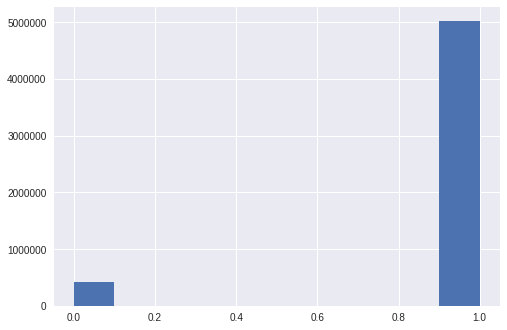

In [0]:
_= train_data['label'].hist()

#matplotlib.pyplot.scatter(train_data['MatchedHit_Z[0]'], train_data['label'])

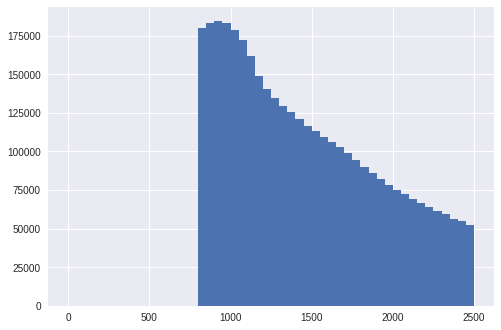

In [0]:
train_data['PT'].hist(bins=50, range=[0, 2500])

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


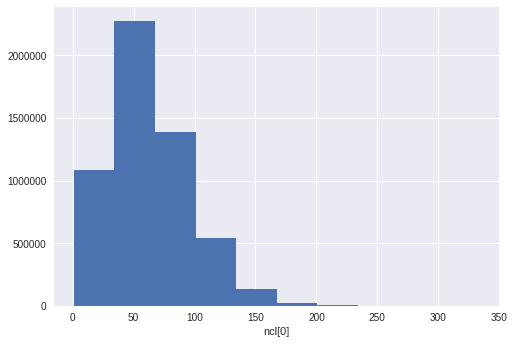

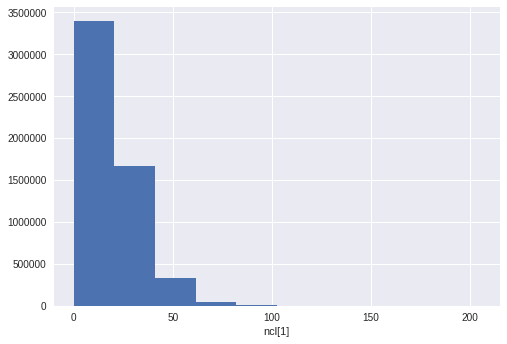

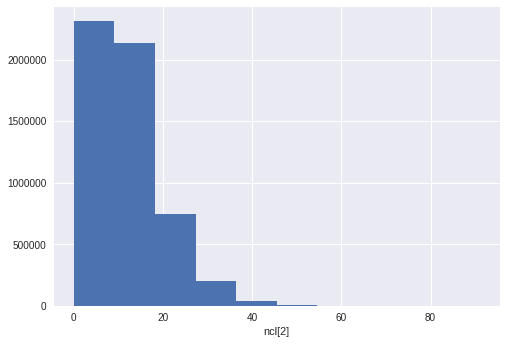

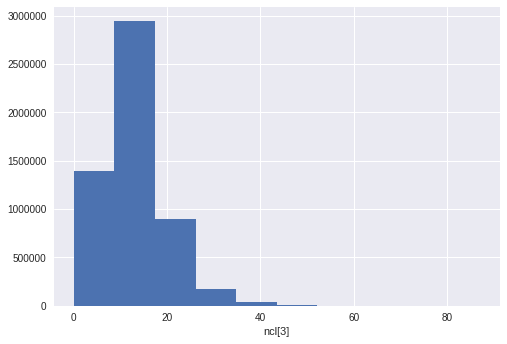

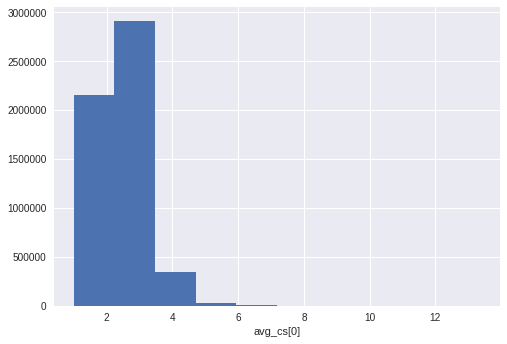

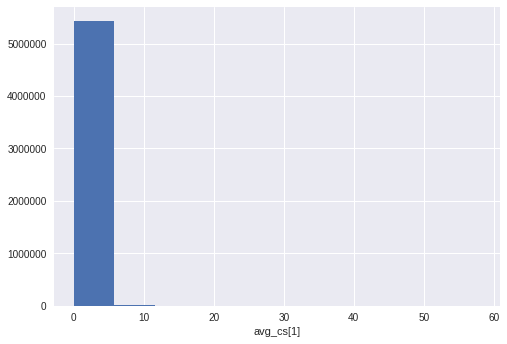

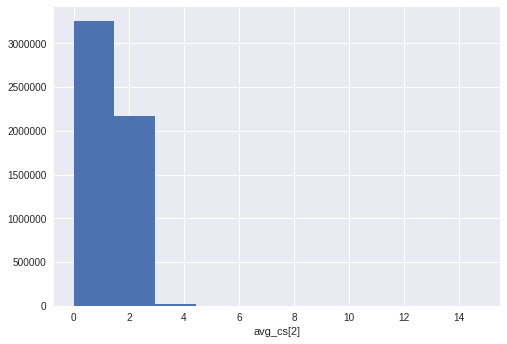

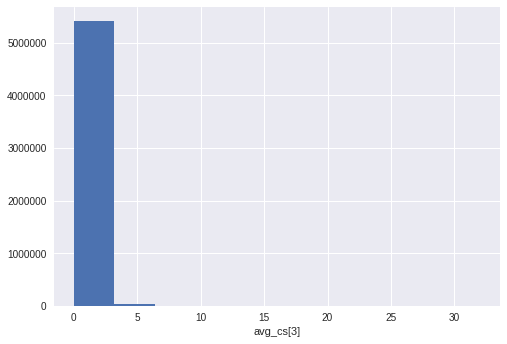

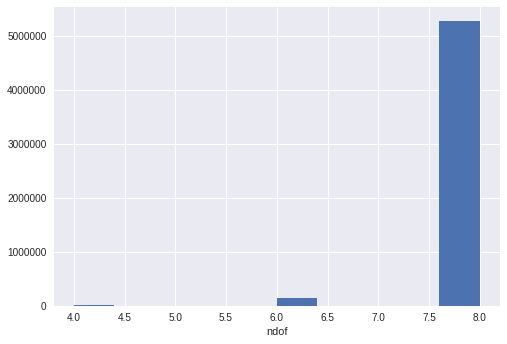

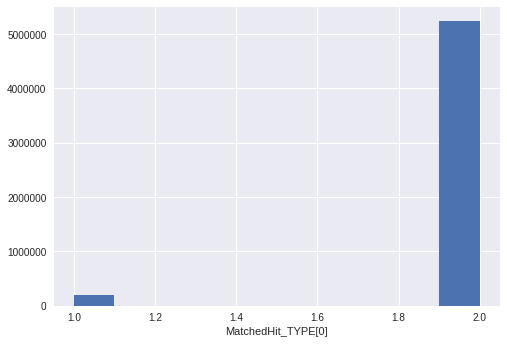

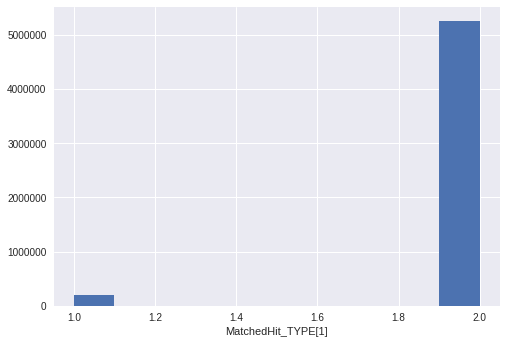

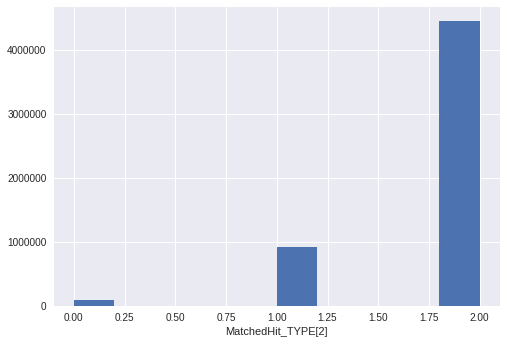

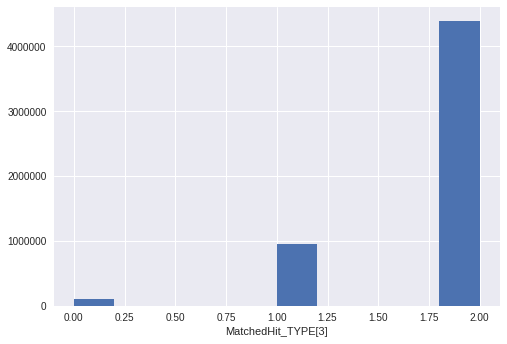

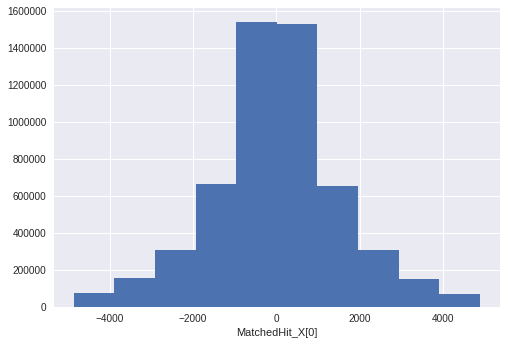

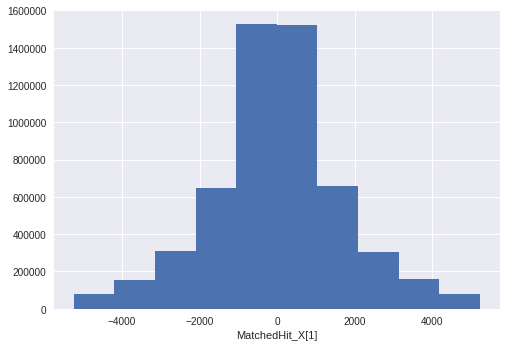

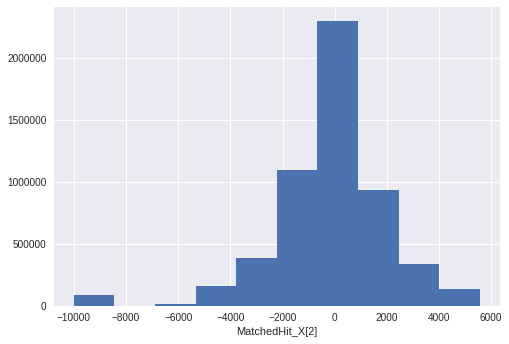

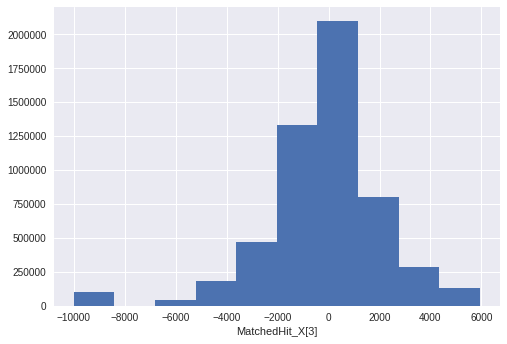

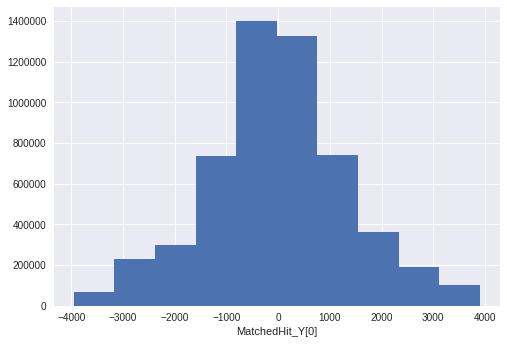

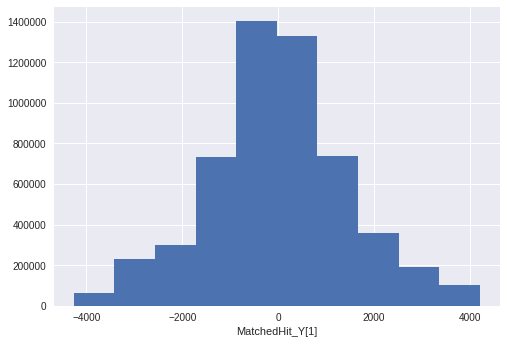

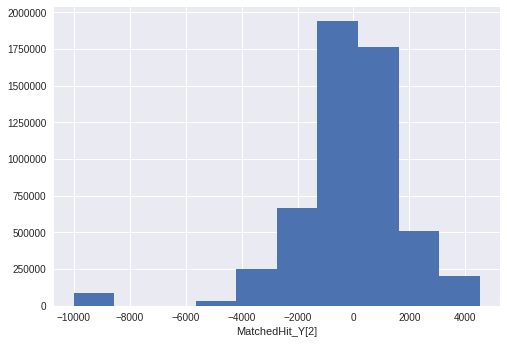

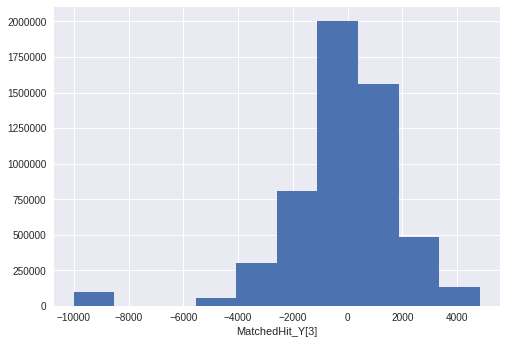

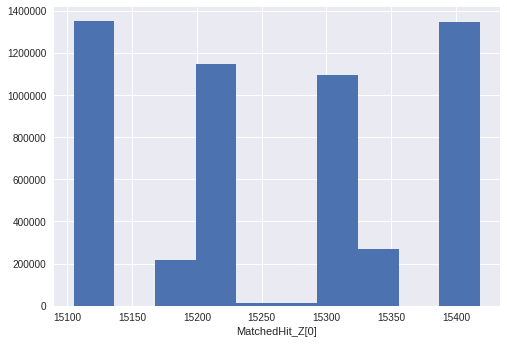

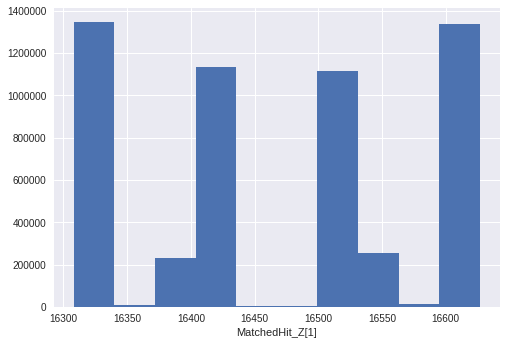

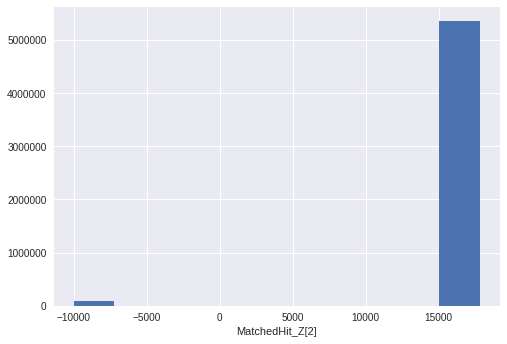

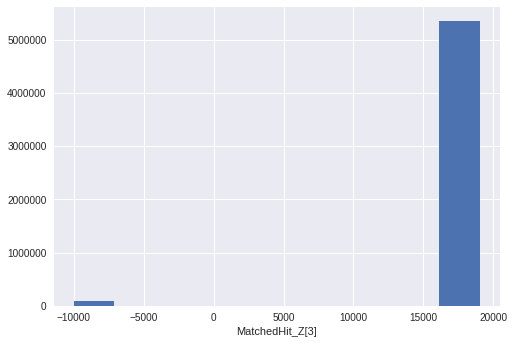

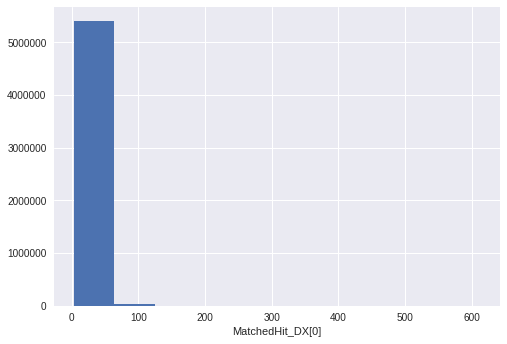

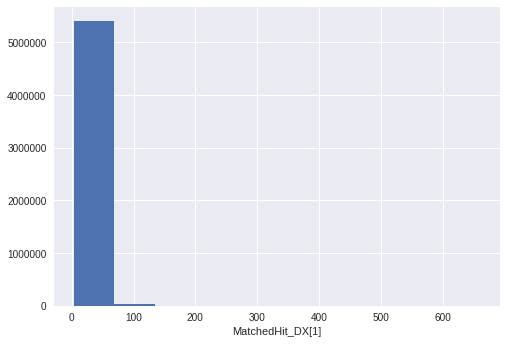

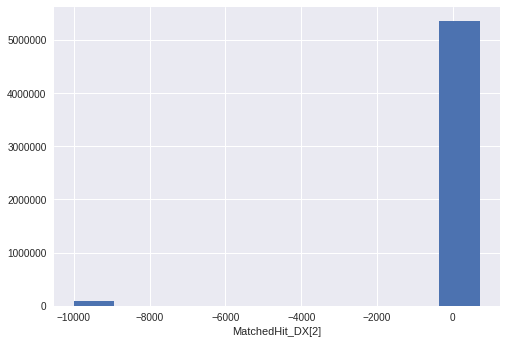

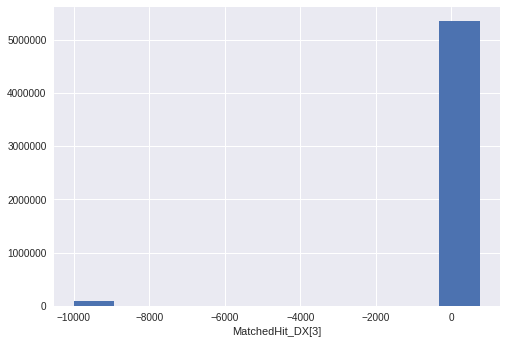

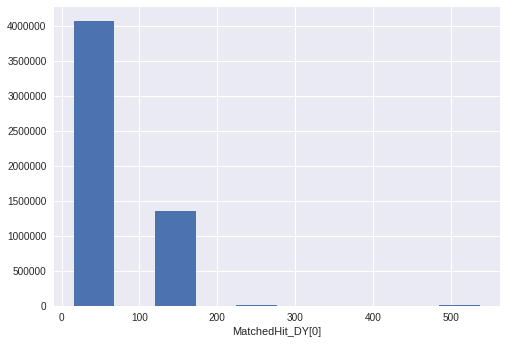

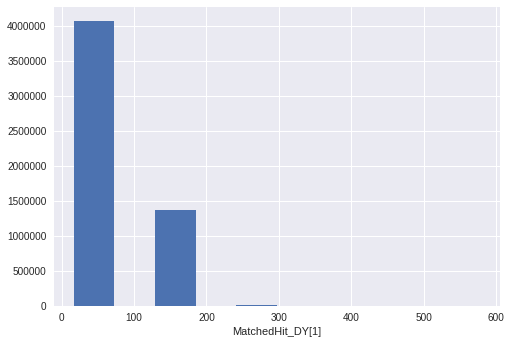

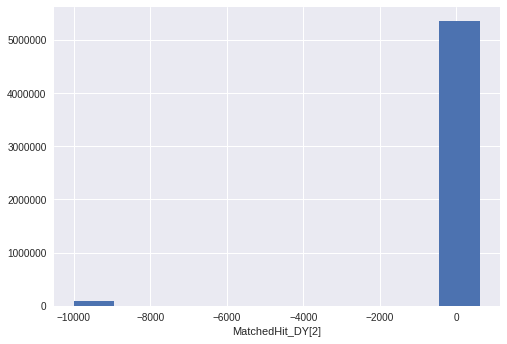

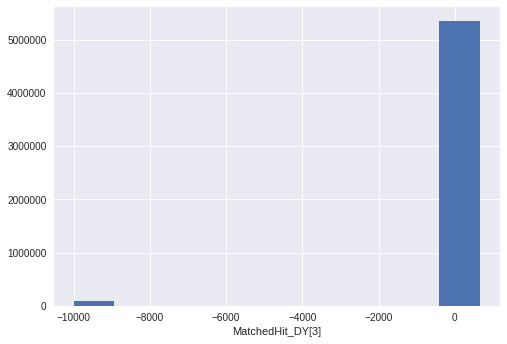

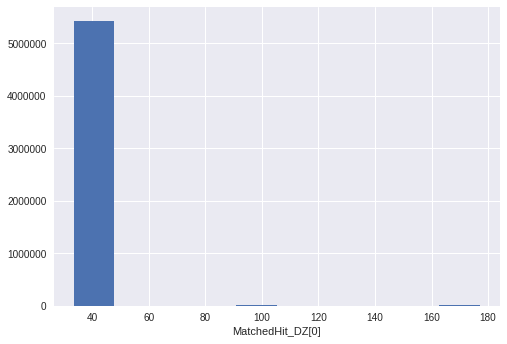

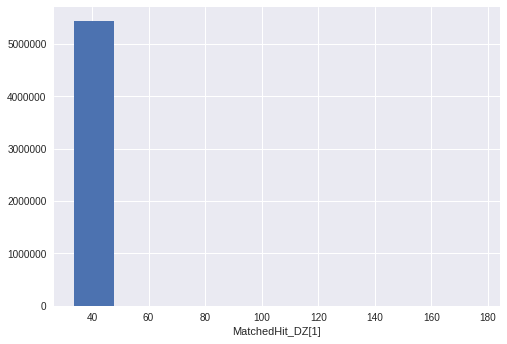

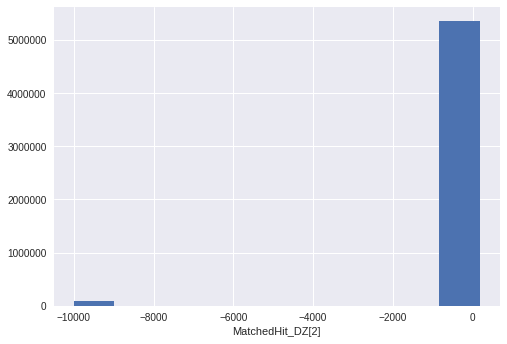

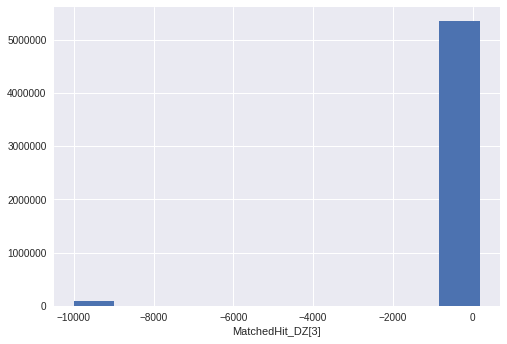

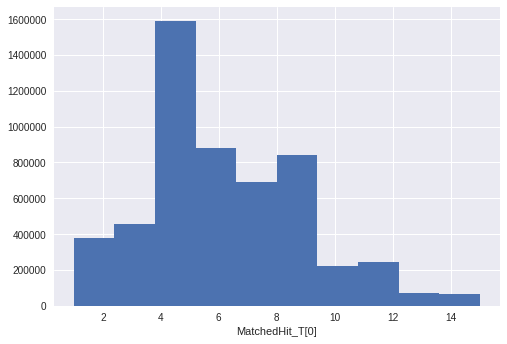

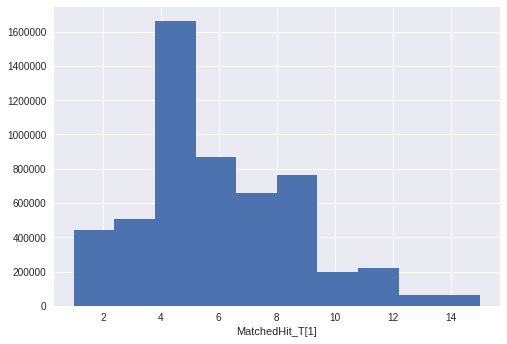

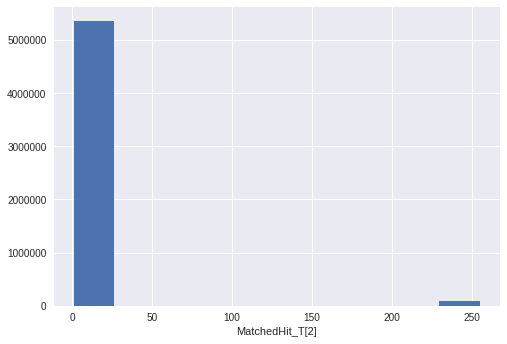

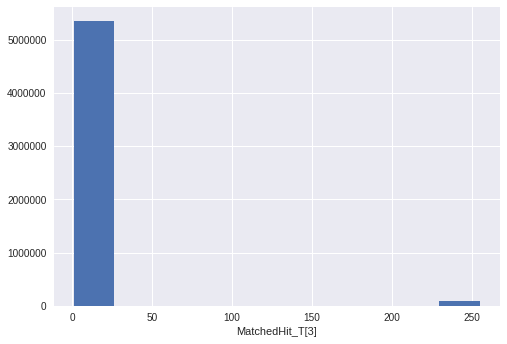

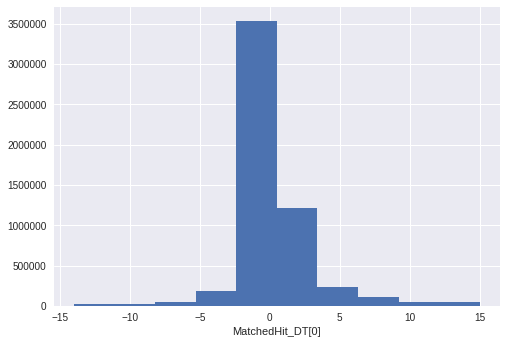

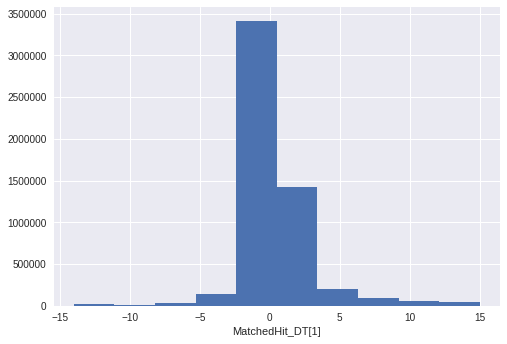

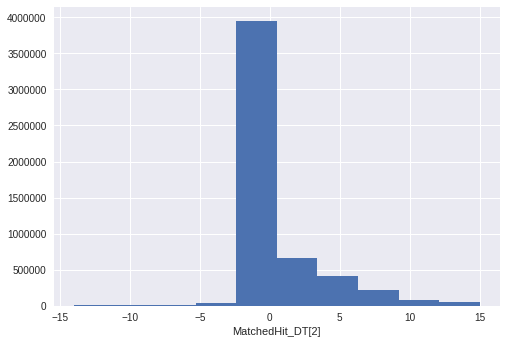

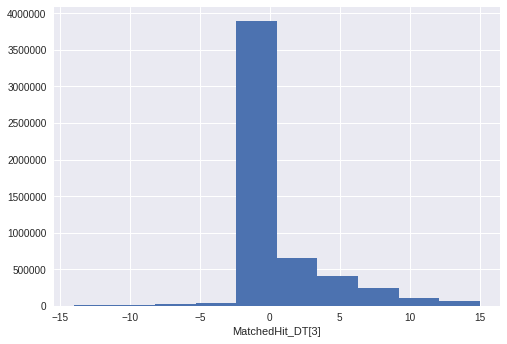

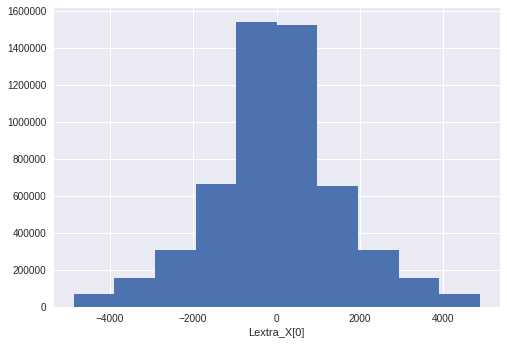

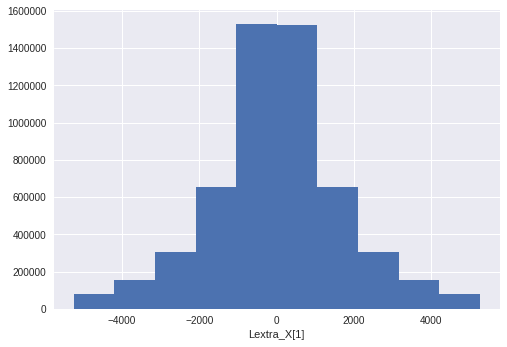

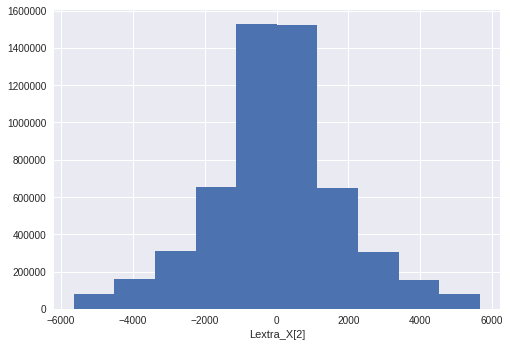

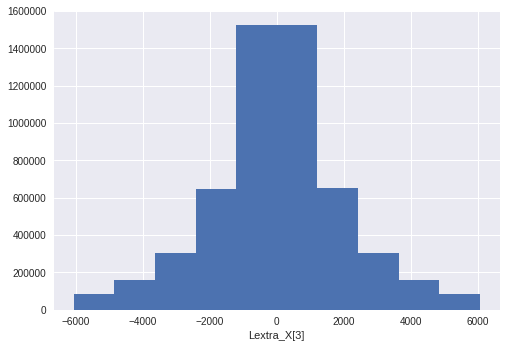

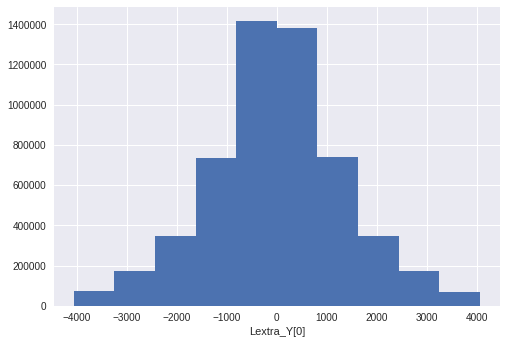

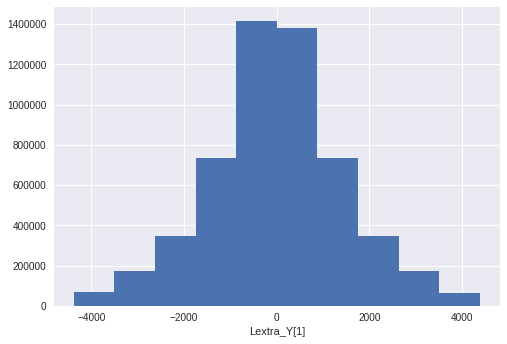

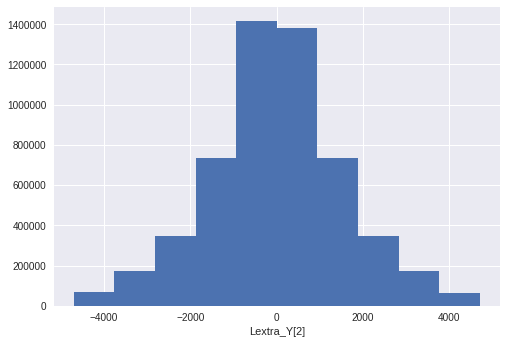

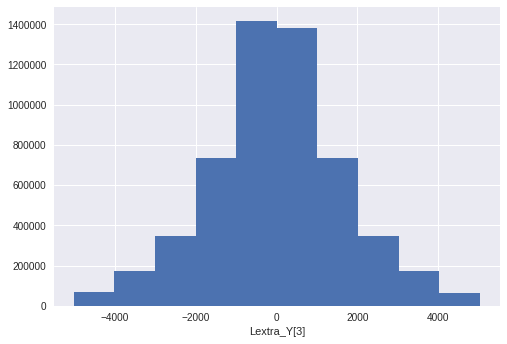

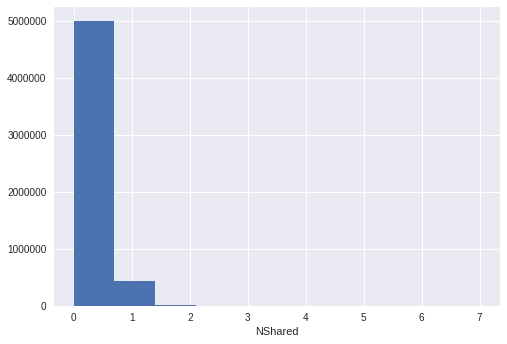

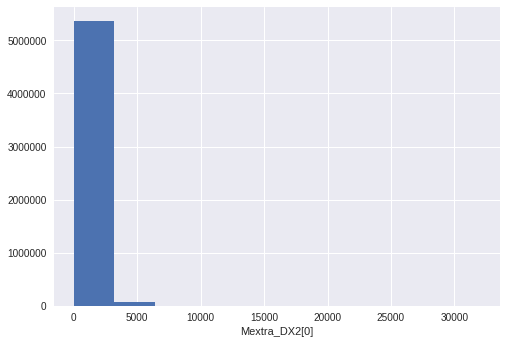

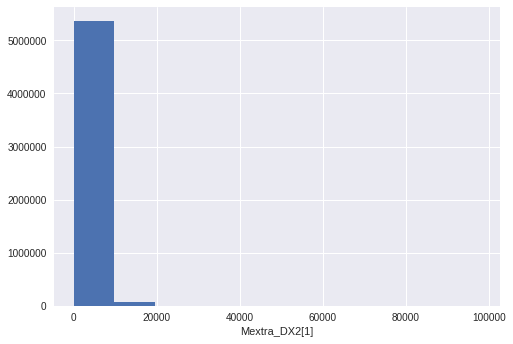

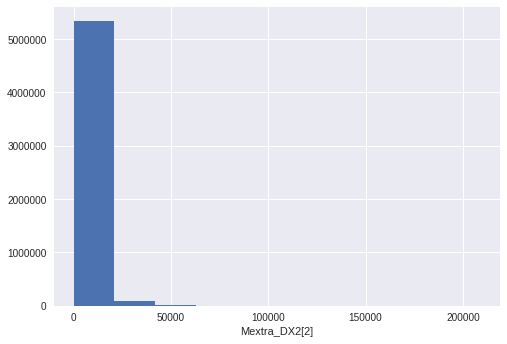

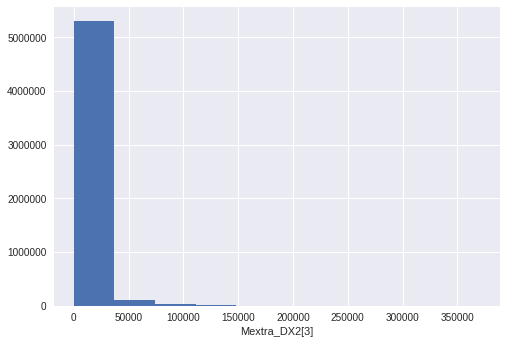

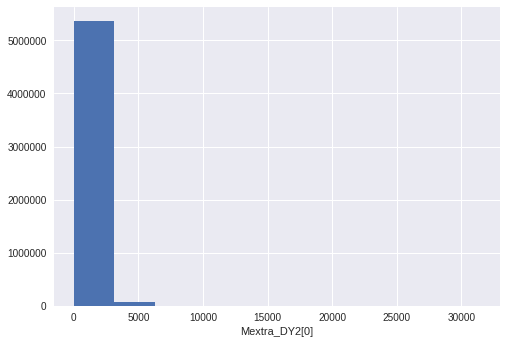

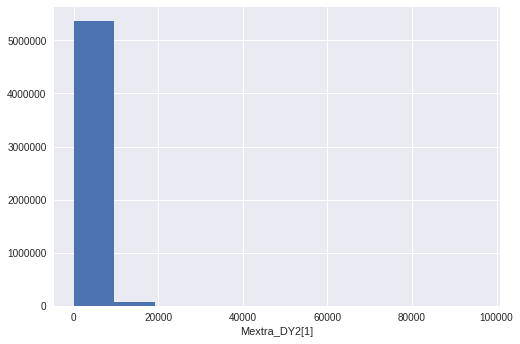

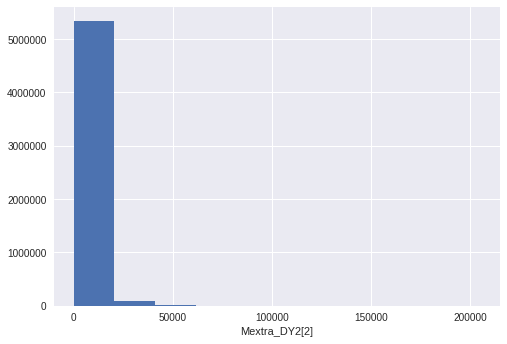

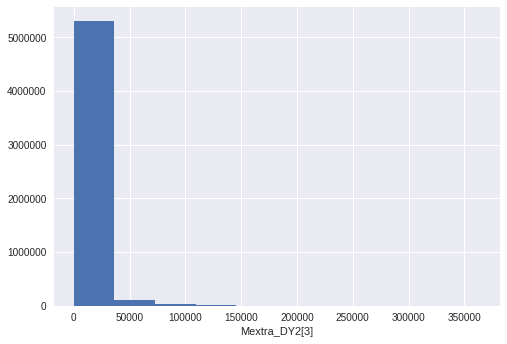

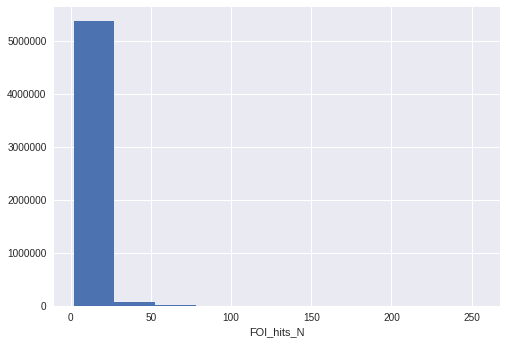

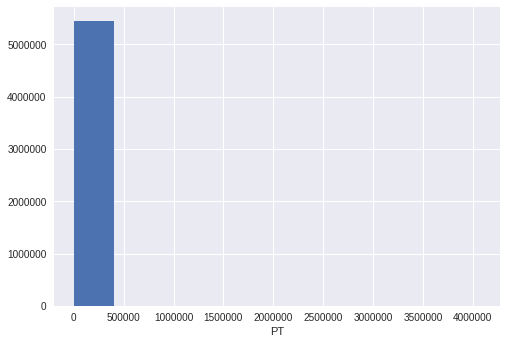

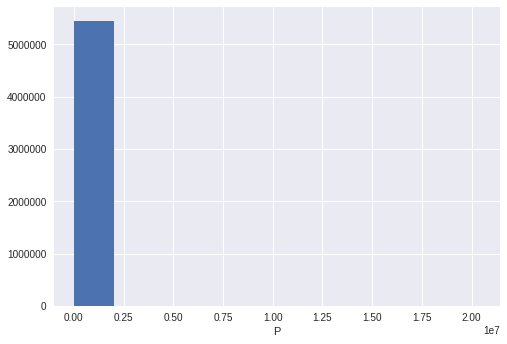

In [0]:
for i in range(0,len(SIMPLE_FEATURE_COLUMNS)):
  
    plt.figure() 
    plt.hist(train_data[SIMPLE_FEATURE_COLUMNS[i]])
    plt.xlabel(SIMPLE_FEATURE_COLUMNS[i])

  


In [0]:


#rename column
train_data = rename_column(train_data)
test_data = rename_column(test_data)

#randomization 
train_data = train_data.reindex(np.random.permutation(train_data.index))
test_data = test_data.reindex(np.random.permutation(test_data.index))


In [0]:
#select amount for traning and testing 
number_raw = 100000
train_data = train_data.head(number_raw)
test_data = test_data.head(int(number_raw * 0.14))

# splite training data into training part and validation part
train_part, validation = train_test_split(train_data, test_size=0.25, shuffle=True)

In [0]:
# Extract the traing features
training_examples = preprocess_features(train_part)
#Extract the traing targets 
training_targets = preprocess_targets(train_part)
#Extract the training weights
training_given_weights = preprocess_given_weights(train_part)

# Extract the validation features
validation_examples = preprocess_features(validation)
#Extract the validation targets 
validation_targets = preprocess_targets(validation)
#Extract the training weights
validation_given_weights = preprocess_given_weights(validation)


# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

print("Training weights summary:")
display.display(training_given_weights.describe())
print("Validation weights summary:")
display.display(validation_given_weights.describe())

In [0]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["label"]

correlation_dataframe.corr()

In [0]:
'''
_ = train_nn_classification_model(
    my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
    steps=500,
    batch_size=25,
    hidden_units=[10],
    training_examples=training_examples,
    training_targets=training_targets,
    training_given_weights=training_given_weights,
    validation_examples=validation_examples,
    validation_targets=validation_targets) '''